# Maximum Likelihood Method

In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import rv_continuous, norm
from scipy.integrate import quad
from iminuit import Minuit

In [2]:
@dataclass
class Likelihood:
    function: callable
    data: np.ndarray

    def __call__(self, *params):
        return np.prod(self.function(self.data, *params))


class NLL(Likelihood):
    def __call__(self, *params):
        return -np.sum([np.log(self.function(self.data, *params))])

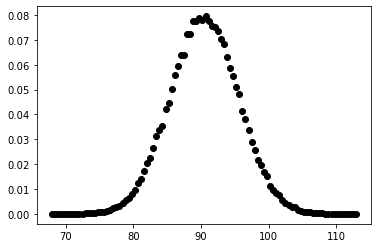

In [12]:
events = 100000
mean = 90
sigma = 5

data = norm.rvs(mean, sigma, size=events)
noise = np.random.uniform(0, 0.01, events)
data += np.multiply(data, noise)

fig, ax = plt.subplots(1, 1)
nbins = 100
histo, edges = np.histogram(data, bins=nbins, density=True)
bin_centers = 0.5 * (edges[1:] + edges[:-1])
ax.plot(bin_centers, histo, 'ko');



In [13]:
def gaussian(x, mu, sigma):
    return (
        1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    )

nll = NLL(gaussian, data)
def to_minimize(mean, sigma):
    return nll(mean, sigma)

minimizer = Minuit(to_minimize, mean=80, sigma=5)
minimizer.errordef = Minuit.LIKELIHOOD
minimizer.migrad()
minimizer.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.033e+05                  │              Nfcn = 69               │
│ EDM = 1.1e-06 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │  90.446   │   0.016   │            │            │         │         │       │
│ 1 │ sigma │   5.022   │   0.011   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     mean    sigma │
├───────┼───────────────────┤
│  mean │ 0.000252 3.15e-08 │
│ sigma │ 3.15e-08 0.000126 │
└───────┴───────────────────┘

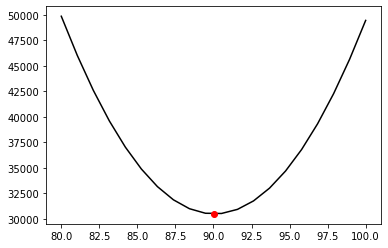

In [5]:
best_mean = minimizer.values['mean']
best_sigma = minimizer.values['sigma']
best_nll = nll(best_mean, best_sigma)

mean_test_values = np.linspace(80, 100, 20)
mean_nlls = np.array([nll(mean, best_sigma) for mean in mean_test_values])

fig, ax = plt.subplots()
ax.plot(mean_test_values, mean_nlls, 'k-');
ax.plot(best_mean, best_nll, 'ro');

/Users/massimiliano/opt/anaconda3/envs/stats-studies/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/var/folders/13/nbt0_qzj025_br3dxm0ph0sh0000gn/T/ipykernel_7714/468126901.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.array([np.log(self.distribution.pdf(x, *params)) for x in self.data]))


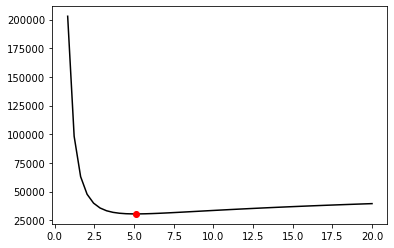

In [6]:
sigma_test_values = np.linspace(0, 20, 50)
sigma_nlss = np.array([nll(best_mean, sigma) for sigma in sigma_test_values])

fig, ax = plt.subplots()
ax.plot(sigma_test_values, sigma_nlss, 'k-');
ax.plot(best_sigma, best_nll, 'ro');

In [7]:
@dataclass
class BinnedNLL:
    distribution: rv_continuous
    histogram: np.ndarray
    edges: np.ndarray

    def __call__(self, *params):
        def probability_distribution_function(x):
            return self.distribution.pdf(x, *params)
        nu = np.array([quad(probability_distribution_function, left, right)[0] for left, right in zip(self.edges[:-1], self.edges[1:])])
        return -np.sum(np.log(np.power(nu, self.histogram)))

In [9]:
bnll = BinnedNLL(norm, histo, edges)
def to_minimize_binned(mean, sigma):
    return bnll(mean, sigma)

minimizer = Minuit(to_minimize_binned, mean=80, sigma=10)
minimizer.errordef = Minuit.LIKELIHOOD
minimizer.migrad()
minimizer.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.812                      │              Nfcn = 90               │
│ EDM = 1.69e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   90.1    │    3.2    │            │            │         │         │       │
│ 1 │ sigma │    5.1    │    2.3    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     mean    sigma │
├───────┼───────────────────┤
│  mean │     10.5 0.000665 │
│ sigma │ 0.000665     5.26 │
└───────┴───────────────────┘